# Deep Learning MTH 5320 
## Homework 3
## 12/6/2023
## By Josias Moukpe

## Object Detection Model Assignment

### Dataset Prep and Preprocessing (20 points)
- Collect or create a dataset of images containing the objects you want to detect annotated with bounding boxes.
- Implement data preprocessing techniques, including:
  - Resizing images
  - Normalizing pixels
- Hint: You can find pre-annotated datasets for download on [Roboflow](https://github.com/roboflow/supervision).

### Model Architecture (30 points)
- Train a YOLOv8 model on your selected dataset using the public repository available at [Ultralytics](https://github.com/ultralytics/ultralytics).
- Monitor the training progress and use appropriate techniques to prevent overfitting.
- Conduct at least 3 tuning experiments.

### Evaluation (20 points)
- Evaluate your trained model's performance on a test dataset using mAP (mean Average Precision).
- Visualize the model's predictions on sample images.
- Analyze the model's performance, discussing any specific failure modes on your test dataset.

In [36]:
# Import libraries
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import datetime
import matplotlib.image as mpimg
from pathlib import Path
from typing import Any, Dict
%matplotlib inline


In [39]:
# Helper functions
def plot_training_results(training_result: Any) -> None:
    """
    Plots the training results from a YOLOv8 model training session.

    Args:
    training_result (Any): The training result object from a YOLOv8 model training. 
                           It must have a 'save_dir' attribute.

    This function looks for 'results.png' in the specified directory and plots it using matplotlib.
    """
    # Extract the save directory from the training result object
    save_dir = training_result.save_dir

    # Path to the training results image
    results_path = Path(save_dir) / 'results.png'

    # Check if the file exists and plot it
    if results_path.exists():
        img = mpimg.imread(str(results_path))
        plt.figure(figsize=(10, 8))  # Adjust the figure size
        plt.imshow(img)
        plt.axis('off')
        plt.title('Training Results', fontsize=16)
        plt.show()
    else:
        print("Training results image not found.")


def plot_evaluation_results(test_result: Any) -> None:
    """
    Plots the confusion matrix and validation batch images from the test results of a YOLOv8 model.

    Args:
    test_result (Any): The test result object from a YOLOv8 model evaluation. It must have a 'save_dir' attribute.

    This function looks for 'confusion_matrix_normalized.png' and 'val_batchX_*' images in the specified directory,
    and plots them using matplotlib.
    """
    # Extract the save directory from the test result object
    save_dir = test_result.save_dir

    # Plot the confusion matrix
    cm_path = Path(save_dir) / 'confusion_matrix_normalized.png'
    if cm_path.exists():
        img = mpimg.imread(str(cm_path))
        plt.figure(figsize=(10, 8))  # Adjust the figure size
        plt.imshow(img)
        plt.axis('off')
        plt.title('Confusion Matrix', fontsize=16)
        plt.show()
    else:
        print("Confusion matrix not found.")

    # Plot validation batch images
    for val_img_path in Path(save_dir).glob('val_batch*_labels.jpg'):
        pred_img_path = Path(str(val_img_path).replace('_labels.jpg', '_pred.jpg'))

        if pred_img_path.exists():
            img_label = mpimg.imread(str(val_img_path))
            img_pred = mpimg.imread(str(pred_img_path))

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(img_label)
            axs[0].axis('off')
            axs[0].set_title('Labels')

            axs[1].imshow(img_pred)
            axs[1].axis('off')
            axs[1].set_title('Predictions')

            plt.show()
        else:
            print(f"Prediction image not found for {val_img_path}.")


def print_evaluation_results(test_result: Any, experiment_name: str) -> None:
    """
    Prints the evaluation results from a YOLOv8 model testing session.

    Args:
    test_result (Any): The test result object from a YOLOv8 model evaluation. 
                       It must have a 'results_dict' attribute containing the evaluation metrics.
    experiment_name (str): The name of the experiment for which the evaluation was done.
    """
    print(f"Evaluation Results for {experiment_name}:")
    for key, value in test_result.results_dict.items():
        print(f"{key:20}: {value:.4f}")

In [40]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using cuda device
NVIDIA GeForce RTX 3060


In [41]:
# configs
SEED = 42

In [42]:
# OCR dataset downloaded from Roboflow in Yolo v8 format
local_ocr_ds_path = 'D:/College/Fall2023/DeepLearning/yolo_ocr'
local_ocr_ds_yaml_path = 'D:/College/Fall2023/DeepLearning/yolo_ocr/data.yaml'
PROJECT_NAME = 'yolov8n_ocr'

In [43]:
# display the yaml file
with open(local_ocr_ds_yaml_path) as f:
    print(f.read())

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 36
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

roboflow:
  workspace: w251ocr
  project: ocr-oy9a7
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/w251ocr/ocr-oy9a7/dataset/1


##### Experiment 1
- Testing baseline default hyperparameters
- To prevent overfitting, I use early stopping, weight decay, and dropout
- Image resizing (to IMGSZ) and normalization (to [0, 1]) is handle by ultralytics library


In [6]:
# loading pre-trained yolov8 model from ultralytics
model_exp1 = YOLO('yolov8n.pt')
# display the model architecture
model_exp1

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [7]:
# format timestamp as string
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# hyperparameters
IMGSZ = 640  # Image resolution for training
EPOCHS = 10  # Number of training epochs
BATCH = 8  # Batch size for training
PATIENCE = 50  # Early stopping patience in epochs
EXP_NAME = f'baseline_yolov8n_ocr_{timestamp}'  # Experiment name with timestamp
OPTIMIZER = 'AdamW'  # Optimization algorithm
VERBOSE = True  # Display detailed training info
FRACTION_TO_TRAIN = 1.0  # Fraction of training set to use
InitLR = 1e-2  # Initial learning rate
FinalLR = 1e-2  # Final learning rate
MOMENTUM = 0.937  # Momentum for optimizer
WEIGHT_DECAY = 5e-4  # Weight decay for regularization
BOX_GAIN = 7.5  # Weight for box loss
CLS_GAIN = 0.5  # Weight for class prediction loss
DFL_GAIN = 1.5  # Weight for directional feature loss
LABEL_SMOOTHING = 0.0  # Label smoothing value
DROPOUT = 0.0  # Dropout rate
USE_VAL = True  # Whether to use a validation set
SAVE_PLOTS = True  # Save training progress plots
USE_PRETRAINED = True  # Use pretrained model weights

# data augmentations
HSV_H = 0.015  # Hue shift (in HSV color space)
HSV_S = 0.7  # Saturation shift
HSV_V = 0.4  # Value (brightness) shift
DEGREES = 0.0  # Max Rotation degrees
TRANSLATE = 0.1  # Translation
SCALE = 0.5  # Scaling
SHEAR = 0.0  # Shearing
PERSPECTIVE = 0.0  # Perspective transformation
FLIPUD = 0.0  # Vertical flip
FLIPLR = 0.5  # Horizontal flip
MOSAIC = 0.0  # Mosaic data augmentation
MIXUP = 0.0  # Mixup data augmentation

# print experiment name
print(EXP_NAME)

# experiment is logged on Wandb
training_results = model_exp1.train(
    # data
    data=local_ocr_ds_yaml_path,
    # hyperparameters
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT_NAME,
    name=EXP_NAME,
    optimizer=OPTIMIZER,
    verbose=VERBOSE,
    fraction=FRACTION_TO_TRAIN,
    lr0=InitLR,
    lrf=FinalLR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    box=BOX_GAIN,
    cls=CLS_GAIN,
    dfl=DFL_GAIN,
    label_smoothing=LABEL_SMOOTHING,
    dropout=DROPOUT,
    val=USE_VAL,
    plots=SAVE_PLOTS,
    pretrained=USE_PRETRAINED,
    seed=SEED,
    # data augmentations
    hsv_h=HSV_H,
    hsv_s=HSV_S,
    hsv_v=HSV_V,
    degrees=DEGREES,
    translate=TRANSLATE,
    scale=SCALE,
    shear=SHEAR,
    perspective=PERSPECTIVE,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    mosaic=MOSAIC,
    mixup=MIXUP
)

baseline_yolov8n_ocr_20231206_113726
New https://pypi.org/project/ultralytics/8.0.222 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/College/Fall2023/DeepLearning/yolo_ocr/data.yaml, epochs=10, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8n_ocr, name=baseline_yolov8n_ocr_20231206_113726, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False,

wandb: Currently logged in as: erud1t3. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\train\labels.cache... 4245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4245/4245 [00:00<?, ?it/s]

train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\03c3dfc7e998b8562_jpg.rf.3d9d76c2437bcfb5cf433c0b6306d1ac.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\185d5dfa193c4ced_jpg.rf.b3d2ab34086b9e8f050b514cc22b4b9a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\24c1fc0bf63da8153_jpg.rf.bd40f6e750b1a7990a9945aadddc1ef1.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\421ca0ce7f9329622_jpg.rf.4e25470bde67152fea6834e88e803708.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\4572990fd64bb6be3_jpg.rf.7ce23d5cd8b919a7832485c4815d97c8.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\492f6d607aae58c12_jpg.rf.44d8f6885cd8664eeff661809ad807ab.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\Co


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\valid\labels.cache... 1221 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1221/1221 [00:00<?, ?it/s]

val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\0ecee0dd32848030_jpg.rf.ffe2fb185ba29646fcf16eacf0e99021.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\22deb87614a920e6_jpg.rf.a72d572c1920415b880c030e7b1a17e6.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\dcb210b4cae8edf22_jpg.rf.286248320e4fe0f26c75339865578ccc.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\f7f068d4fb49a4f34_jpg.rf.8856a3518481e9dcc022b1a802a966cd.jpg: 1 duplicate labels removed


Plotting labels to yolov8n_ocr\baseline_yolov8n_ocr_20231206_113726\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8n_ocr\baseline_yolov8n_ocr_20231206_113726
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.55G      1.231       2.35      1.187         21        640: 100%|██████████| 531/531 [01:07<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:17<00:00,  4.34it/s]


                   all       1221       7890      0.448      0.535      0.455      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.56G      1.127      1.335      1.158         31        640: 100%|██████████| 531/531 [01:00<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.51it/s]


                   all       1221       7890      0.762      0.748      0.786      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.56G      1.046      1.037      1.117         34        640: 100%|██████████| 531/531 [00:59<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  5.95it/s]

                   all       1221       7890      0.814      0.767       0.84      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.56G     0.9731     0.8642      1.086         29        640: 100%|██████████| 531/531 [00:58<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.32it/s]


                   all       1221       7890      0.871      0.782      0.868      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.55G      0.954     0.8092      1.073         35        640: 100%|██████████| 531/531 [00:57<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.41it/s]


                   all       1221       7890      0.867      0.788      0.867      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.56G     0.9036     0.7318      1.051         28        640: 100%|██████████| 531/531 [00:57<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.41it/s]

                   all       1221       7890      0.905      0.836      0.906      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.56G     0.8707     0.6685      1.034         31        640: 100%|██████████| 531/531 [00:57<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.33it/s]

                   all       1221       7890      0.917      0.836       0.91      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.56G     0.8506     0.6128      1.026         28        640: 100%|██████████| 531/531 [00:58<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.40it/s]

                   all       1221       7890      0.911      0.863      0.928      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.56G     0.8155     0.5774      1.006         23        640: 100%|██████████| 531/531 [00:58<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.31it/s]

                   all       1221       7890      0.934      0.872      0.936      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.56G     0.7864     0.5389     0.9929         32        640: 100%|██████████| 531/531 [00:57<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.32it/s]

                   all       1221       7890      0.928      0.881      0.941      0.732



10 epochs completed in 0.211 hours.
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_113726\weights\last.pt, 6.2MB
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_113726\weights\best.pt, 6.2MB

Validating yolov8n_ocr\baseline_yolov8n_ocr_20231206_113726\weights\best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:14<00:00,  5.33it/s]


                   all       1221       7890      0.927      0.881      0.941      0.732
                     0       1221        408       0.78        0.9      0.877      0.686
                     1       1221        386      0.883      0.864      0.942      0.655
                     2       1221        399      0.963      0.971       0.99      0.758
                     3       1221        369      0.959      0.951      0.978      0.775
                     4       1221        326      0.974      0.928      0.972       0.73
                     5       1221        383       0.95      0.951      0.983      0.781
                     6       1221        393      0.979      0.972      0.992      0.771
                     7       1221        343      0.985      0.981      0.992       0.76
                     8       1221        346      0.922      0.913      0.972      0.756
                     9       1221        324      0.953      0.978      0.991      0.784
                     

lr/pg0,█▅▂▂▂▁▁▁▁▁
lr/pg1,▂▆█▇▇▆▅▃▂▁
lr/pg2,▂▆█▇▇▆▅▃▂▁
metrics/mAP50(B),▁▆▇▇▇▇████
metrics/mAP50-95(B),▁▅▆▇▇▇▇███
metrics/precision(B),▁▆▆▇▇█████
metrics/recall(B),▁▅▆▆▆▇▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▄▄▃▂▂▁▁


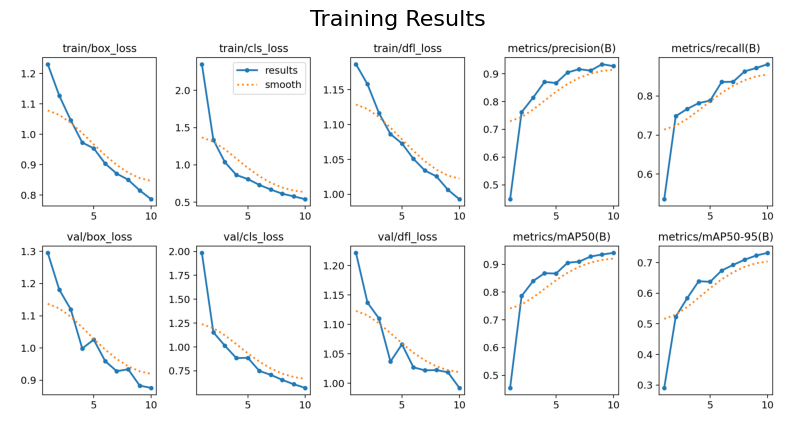

In [44]:
# display the sum training results
plot_training_results(training_results)

In [9]:
# Eval parameters
VAL_BATCH = 64
VAL_PLOTS = True
VAL_SPLIT = 'test'
# evaluate the model on the test dataset
test_results = model_exp1.val(
    data=local_ocr_ds_yaml_path,
    imgsz=IMGSZ,
    plots=VAL_PLOTS,
    split=VAL_SPLIT)

Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\test\labels.cache... 610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.86it/s]


                   all        610       3954      0.891      0.857       0.91      0.682
                     0        610        231      0.719      0.876       0.81      0.598
                     1        610        239      0.869      0.816      0.919      0.602
                     2        610        191      0.954      0.972      0.993      0.743
                     3        610        186      0.945      0.921      0.967      0.729
                     4        610        160      0.952      0.919      0.977      0.745
                     5        610        205      0.942      0.961      0.991      0.766
                     6        610        226      0.994       0.92      0.982      0.734
                     7        610        197      0.972      0.944      0.981      0.736
                     8        610        177       0.92      0.927      0.963      0.739
                     9        610        185      0.928      0.969      0.984      0.762
                     

In [34]:
# print evaluation results
print_evaluation_results(test_results, EXP_NAME)

Evaluation Results for baseline_yolov8n_ocr_20231206_113726:
metrics/precision(B): 0.8907
metrics/recall(B)   : 0.8569
metrics/mAP50(B)    : 0.9102
metrics/mAP50-95(B) : 0.6824
fitness             : 0.7052


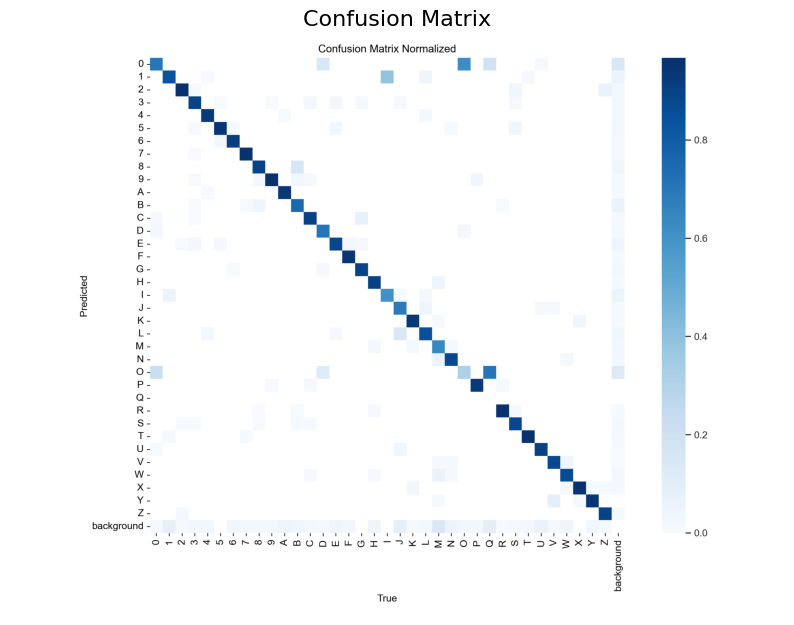

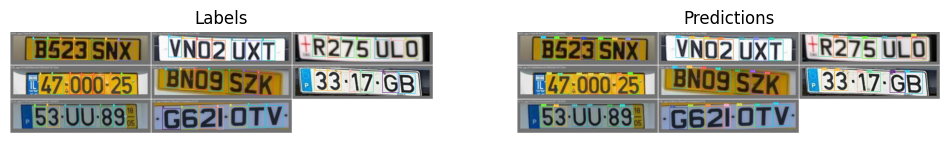

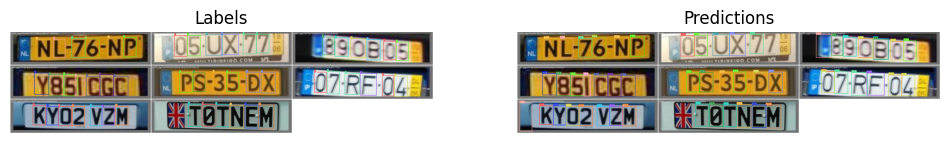

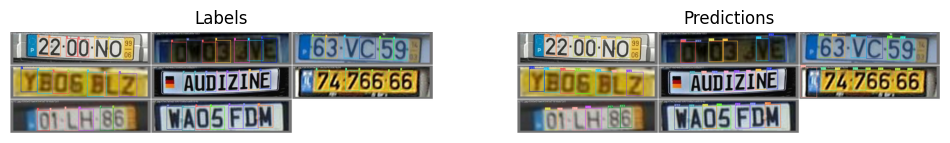

In [45]:
# visualization of results
plot_evaluation_results(test_results)

Discussion

We can see from the confusion plot that this model exp 1 is struggling with O and Q as they are very similar

##### Experiment 2
- Testing following hyperparameter updates

- To prevent overfitting, I use early stopping, weight decay, and dropout
- Image resizing (to IMGSZ) and normalization (to [0, 1]) is handle by ultralytics library

In [ ]:
# loading pre-trained yolov8 model from ultralytics
model_exp2 = YOLO('yolov8n.pt')
# display the model architecture
model_exp2

##### Experiment 3
- Testing following hyperparameter updates

- To prevent overfitting, I use early stopping, weight decay, and dropout
- Image resizing (to IMGSZ) and normalization (to [0, 1]) is handle by ultralytics library

In [ ]:
# loading pre-trained yolov8 model from ultralytics
model_exp3 = YOLO('yolov8n.pt')
# display the model architecture
model_exp3

##### Experiment 4
- Testing following hyperparameter updates

- To prevent overfitting, I use early stopping, weight decay, and dropout
- Image resizing (to IMGSZ) and normalization (to [0, 1]) is handle by ultralytics library

In [ ]:
# loading pre-trained yolov8 model from ultralytics
model_exp4 = YOLO('yolov8n.pt')
# display the model architecture
model_exp4

##### Final Run

In [ ]:
# loading pre-trained yolov8 model from ultralytics
final_model = YOLO('yolov8n.pt')
# display the model architecture
final_model

### BONUS (25 bonus points)
- Design and train a custom CNN-based object detection model using a self-designed architecture.
- Alternatively, compare several publicly available models on the same dataset.
- Consider implementing Gaussian YOLO V8 and comparing it against YOLO V8.

Please ensure that your code includes docstrings and type hints as requested, and be thorough in your analysis and experimentation.

### Custom Yolo G8 Architecture in Pytorch (NO UltraLytics here unfortunately)